### 3. ResNet18 (fine tuning) with data augmentation and increased image resolution (224x224) [best model]

##### Colab

Prepairing setup & dataset to run notebook in Google Colab

In [18]:
# Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -q kaggle

In [19]:
from google.colab import userdata
import os

os.environ["kaggle_key"] = userdata.get('kaggle_key')
os.environ["kaggle_username"] = userdata.get('kaggle_username')

In [ ]:
!kaggle datasets download -d ravidussilva/real-ai-art
! unzip "real-ai-art"

##### Local & Colab

Import dataset & all supporting files

In [20]:
# Define paths for all supporting files & dataset
import sys

# Check if the code is running in Colab
IN_COLAB = 'google.colab' in sys.modules

if not IN_COLAB:
    # Load environment variables from .env file
    from dotenv import load_dotenv
    load_dotenv()
    project_root = os.getenv('PROJECT_ROOT_PATH')
    dataset_path = os.getenv('DATASET_PATH')
else:
    # Set the project root path for Colab
    project_root = userdata.get("project_root_path")
    dataset_path = userdata.get("dataset_path")

# Check if the project root path is set correctly
if project_root is None:
    raise ValueError("PROJECT_ROOT_PATH environment variable is not set.")

# Add the project root path to the system path
sys.path.append(project_root)

In [22]:
#data preprocessing
from scripts.viz import display_images
from datasets.AIArtBench import AIArtbench
from datasets.dataset import Subset
from datasets.preprocessing import CustomDatasetPreprocessor
import torch.utils.data as data
import torchvision.transforms as transforms

#model
from scripts.run_cnn import train_model, test_model
from models.resnet18 import ResNet18FineTuned
from scripts.evaluation import analyze_test_results

#support
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

#### Train & test using transfer learning (ResNet18)

Prepaire dataset and training setup:

- Rotation, Vertical and Horizontal flips are used as data augmentation steps
- Images are passed using higher resolution (224 x 224)
- We do not freeze any layers for training

In [ ]:
# Updated train_transform with data augmentation
train_transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),         # Randomly flip the image horizontally
      transforms.RandomVerticalFlip(),         # Randomly flip the image vertically
      transforms.RandomRotation(30),             # Randomly rotate images by up to 30 degrees
      transforms.Resize(size=(224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Validation and test transforms (without augmentation)
val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


# Config for training and testing
config = {
    'model': ResNet18FineTuned(freeze_layers=False),
    'dataset_path': dataset_path,
    'model_save_dir': 'saved_models',
    'results_save_dir': 'saved_results',
    'train_transform': train_transform,
    'val_transform': val_transform,
    'test_transform': test_transform,
    'batch_size': 64,
    'learning_rate': 0.001,
    'scheduler_gamma': 0.9,
    'epochs': 10,
    'fraction': 1,
    'val_frequency': 1,
    'debug_mode': True,
    'patience': 3,
    'model_name': "ResNet18"
}

# Train the model

trainer_resnet = train_model(config)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


List of parameters that require gradients:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1

wandb: Currently logged in as: ovsvc (ovsvc-tu-wien). Use `wandb login --relogin` to force relogin


Model: ResNet18FineTuned(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

Training with batch size: 64
Epoch 0/10:
--- Training epoch 0 ---


Train:   0%|          | 1/1407 [00:01<43:54,  1.87s/it]

Batch 0, Loss: 3.2085072994232178


Train:  36%|███▌      | 501/1407 [04:14<08:16,  1.82it/s]

Batch 500, Loss: 1.0107593536376953


Train:  71%|███████   | 1001/1407 [08:22<03:38,  1.86it/s]

Batch 1000, Loss: 0.8396713733673096


Train: 100%|██████████| 1407/1407 [11:46<00:00,  1.99it/s]


Epoch 0 Training Loss: 1.0904447515699598
Training Metrics: Overall Accuracy: 0.6272
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.90
Accuracy for class AI_surrealism: 0.79
Accuracy for class human_art_nouveau: 0.90
Accuracy for class human_expressionism: 0.75
Accuracy for class human_ukiyo_e: 0.73
Accuracy for class AI_renaissance: 0.76
Accuracy for class AI_art_nouveau: 0.79
Accuracy for class human_realism: 0.78
Accuracy for class AI_realism: 0.88
Accuracy for class human_post_impressionism: 0.95
Accuracy for class human_romanticism: 0.38
Accuracy for class AI_expressionism: 0.46
Accuracy for class AI_baroque: 0.29
Accuracy for class AI_impressionism: 0.42
Accuracy for class human_surrealism: 0.33
Accuracy for class human_renaissance: 0.22
Accuracy for class AI_post_impressionism: 0.49
Accuracy for class AI_ukiyo-e: 0.28
Accuracy for class human_impressionism: 0.55
Accuracy for class AI_romanticism: 0.88
--- Validating epoch 0 ---


Evaluate:   1%|          | 1/157 [00:00<00:55,  2.81it/s]

Batch 0, Validation Loss: 0.7338129878044128


Evaluate: 100%|██████████| 157/157 [01:02<00:00,  2.51it/s]


Epoch 0 Validation Loss: 0.7822590190887451
Validation Metrics: Overall Accuracy: 0.7147
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.98
Accuracy for class AI_ukiyo-e: 0.86
Accuracy for class AI_romanticism: 0.96
Accuracy for class AI_art_nouveau: 0.92
Accuracy for class human_surrealism: 0.68
Accuracy for class AI_renaissance: 0.89
Accuracy for class AI_realism: 0.91
Accuracy for class human_ukiyo_e: 0.92
Accuracy for class human_art_nouveau: 0.98
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.46
Accuracy for class human_impressionism: 0.57
Accuracy for class AI_impressionism: 0.42
Accuracy for class human_renaissance: 0.35
Accuracy for class human_expressionism: 0.46
Accuracy for class human_realism: 0.34
Accuracy for class AI_baroque: 0.62
Accuracy for class human_post_impressionism: 0.32
Accuracy for class AI_surrealism: 0.73
Accuracy for class AI_expressionism: 0.91
#### Best accuracy 0.7147 at epoch 0
#### Saving model to saved_

Train:   0%|          | 1/1407 [00:00<12:41,  1.85it/s]

Batch 0, Loss: 1.2573820352554321


Train:  36%|███▌      | 501/1407 [04:09<07:51,  1.92it/s]

Batch 500, Loss: 0.7578305602073669


Train:  71%|███████   | 1001/1407 [08:19<03:15,  2.07it/s]

Batch 1000, Loss: 0.9640346765518188


Train: 100%|██████████| 1407/1407 [11:43<00:00,  2.00it/s]


Epoch 1 Training Loss: 0.772183169444402
Training Metrics: Overall Accuracy: 0.7166
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.96
Accuracy for class AI_surrealism: 0.90
Accuracy for class human_art_nouveau: 0.95
Accuracy for class human_expressionism: 0.82
Accuracy for class human_ukiyo_e: 0.81
Accuracy for class AI_renaissance: 0.88
Accuracy for class AI_art_nouveau: 0.90
Accuracy for class human_realism: 0.89
Accuracy for class AI_realism: 0.94
Accuracy for class human_post_impressionism: 0.99
Accuracy for class human_romanticism: 0.51
Accuracy for class AI_expressionism: 0.57
Accuracy for class AI_baroque: 0.41
Accuracy for class AI_impressionism: 0.45
Accuracy for class human_surrealism: 0.39
Accuracy for class human_renaissance: 0.31
Accuracy for class AI_post_impressionism: 0.65
Accuracy for class AI_ukiyo-e: 0.37
Accuracy for class human_impressionism: 0.68
Accuracy for class AI_romanticism: 0.94
--- Validating epoch 1 ---


Evaluate:   1%|          | 1/157 [00:00<00:56,  2.77it/s]

Batch 0, Validation Loss: 0.6509413123130798


Evaluate: 100%|██████████| 157/157 [01:02<00:00,  2.51it/s]


Epoch 1 Validation Loss: 0.710127140045166
Validation Metrics: Overall Accuracy: 0.7390
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.99
Accuracy for class AI_ukiyo-e: 0.95
Accuracy for class AI_romanticism: 0.97
Accuracy for class AI_art_nouveau: 0.76
Accuracy for class human_surrealism: 0.87
Accuracy for class AI_renaissance: 0.90
Accuracy for class AI_realism: 0.90
Accuracy for class human_ukiyo_e: 0.91
Accuracy for class human_art_nouveau: 0.99
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.49
Accuracy for class human_impressionism: 0.63
Accuracy for class AI_impressionism: 0.33
Accuracy for class human_renaissance: 0.50
Accuracy for class human_expressionism: 0.48
Accuracy for class human_realism: 0.18
Accuracy for class AI_baroque: 0.65
Accuracy for class human_post_impressionism: 0.56
Accuracy for class AI_surrealism: 0.75
Accuracy for class AI_expressionism: 0.97
#### Best accuracy 0.739 at epoch 1
#### Saving model to saved_mo

Train:   0%|          | 1/1407 [00:00<10:08,  2.31it/s]

Batch 0, Loss: 0.9449735879898071


Train:  36%|███▌      | 501/1407 [04:08<07:12,  2.09it/s]

Batch 500, Loss: 0.7820910215377808


Train:  71%|███████   | 1001/1407 [08:17<03:29,  1.93it/s]

Batch 1000, Loss: 0.6281500458717346


Train: 100%|██████████| 1407/1407 [11:37<00:00,  2.02it/s]


Epoch 2 Training Loss: 0.7065756243387858
Training Metrics: Overall Accuracy: 0.7377
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.97
Accuracy for class AI_surrealism: 0.92
Accuracy for class human_art_nouveau: 0.95
Accuracy for class human_expressionism: 0.83
Accuracy for class human_ukiyo_e: 0.83
Accuracy for class AI_renaissance: 0.90
Accuracy for class AI_art_nouveau: 0.92
Accuracy for class human_realism: 0.90
Accuracy for class AI_realism: 0.96
Accuracy for class human_post_impressionism: 1.00
Accuracy for class human_romanticism: 0.53
Accuracy for class AI_expressionism: 0.62
Accuracy for class AI_baroque: 0.44
Accuracy for class AI_impressionism: 0.46
Accuracy for class human_surrealism: 0.43
Accuracy for class human_renaissance: 0.34
Accuracy for class AI_post_impressionism: 0.69
Accuracy for class AI_ukiyo-e: 0.41
Accuracy for class human_impressionism: 0.71
Accuracy for class AI_romanticism: 0.95
--- Validating epoch 2 ---


Evaluate:   1%|          | 1/157 [00:00<00:55,  2.80it/s]

Batch 0, Validation Loss: 0.6192373633384705


Evaluate: 100%|██████████| 157/157 [01:05<00:00,  2.41it/s]


Epoch 2 Validation Loss: 0.6720794570922851
Validation Metrics: Overall Accuracy: 0.7535
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.98
Accuracy for class AI_ukiyo-e: 0.89
Accuracy for class AI_romanticism: 0.97
Accuracy for class AI_art_nouveau: 0.79
Accuracy for class human_surrealism: 0.90
Accuracy for class AI_renaissance: 0.87
Accuracy for class AI_realism: 0.97
Accuracy for class human_ukiyo_e: 0.92
Accuracy for class human_art_nouveau: 0.99
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.55
Accuracy for class human_impressionism: 0.55
Accuracy for class AI_impressionism: 0.38
Accuracy for class human_renaissance: 0.51
Accuracy for class human_expressionism: 0.43
Accuracy for class human_realism: 0.27
Accuracy for class AI_baroque: 0.84
Accuracy for class human_post_impressionism: 0.52
Accuracy for class AI_surrealism: 0.78
Accuracy for class AI_expressionism: 0.97
#### Best accuracy 0.7535 at epoch 2
#### Saving model to saved_

Train:   0%|          | 1/1407 [00:00<13:22,  1.75it/s]

Batch 0, Loss: 0.8765584230422974


Train:  36%|███▌      | 501/1407 [04:10<07:20,  2.06it/s]

Batch 500, Loss: 0.6789233684539795


Train:  71%|███████   | 1001/1407 [08:17<03:15,  2.07it/s]

Batch 1000, Loss: 1.053551197052002


Train: 100%|██████████| 1407/1407 [11:39<00:00,  2.01it/s]


Epoch 3 Training Loss: 0.670107504526774
Training Metrics: Overall Accuracy: 0.7522
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.97
Accuracy for class AI_surrealism: 0.93
Accuracy for class human_art_nouveau: 0.96
Accuracy for class human_expressionism: 0.84
Accuracy for class human_ukiyo_e: 0.84
Accuracy for class AI_renaissance: 0.91
Accuracy for class AI_art_nouveau: 0.94
Accuracy for class human_realism: 0.91
Accuracy for class AI_realism: 0.96
Accuracy for class human_post_impressionism: 1.00
Accuracy for class human_romanticism: 0.58
Accuracy for class AI_expressionism: 0.63
Accuracy for class AI_baroque: 0.47
Accuracy for class AI_impressionism: 0.47
Accuracy for class human_surrealism: 0.45
Accuracy for class human_renaissance: 0.35
Accuracy for class AI_post_impressionism: 0.72
Accuracy for class AI_ukiyo-e: 0.43
Accuracy for class human_impressionism: 0.72
Accuracy for class AI_romanticism: 0.96
--- Validating epoch 3 ---


Evaluate:   1%|          | 1/157 [00:00<01:06,  2.34it/s]

Batch 0, Validation Loss: 0.5867917537689209


Evaluate: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]


Epoch 3 Validation Loss: 0.6564907995223999
Validation Metrics: Overall Accuracy: 0.7587
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.99
Accuracy for class AI_ukiyo-e: 0.92
Accuracy for class AI_romanticism: 0.97
Accuracy for class AI_art_nouveau: 0.90
Accuracy for class human_surrealism: 0.79
Accuracy for class AI_renaissance: 0.94
Accuracy for class AI_realism: 0.96
Accuracy for class human_ukiyo_e: 0.92
Accuracy for class human_art_nouveau: 0.99
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.54
Accuracy for class human_impressionism: 0.61
Accuracy for class AI_impressionism: 0.30
Accuracy for class human_renaissance: 0.48
Accuracy for class human_expressionism: 0.56
Accuracy for class human_realism: 0.36
Accuracy for class AI_baroque: 0.70
Accuracy for class human_post_impressionism: 0.46
Accuracy for class AI_surrealism: 0.81
Accuracy for class AI_expressionism: 0.98
#### Best accuracy 0.7587 at epoch 3
#### Saving model to saved_

Train:   0%|          | 1/1407 [00:00<11:20,  2.07it/s]

Batch 0, Loss: 0.5767033100128174


Train:  36%|███▌      | 501/1407 [04:13<07:54,  1.91it/s]

Batch 500, Loss: 0.706063985824585


Train:  71%|███████   | 1001/1407 [08:27<03:14,  2.09it/s]

Batch 1000, Loss: 0.5145227313041687


Train: 100%|██████████| 1407/1407 [11:50<00:00,  1.98it/s]


Epoch 4 Training Loss: 0.6436507671144274
Training Metrics: Overall Accuracy: 0.7620
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.98
Accuracy for class AI_surrealism: 0.94
Accuracy for class human_art_nouveau: 0.97
Accuracy for class human_expressionism: 0.85
Accuracy for class human_ukiyo_e: 0.85
Accuracy for class AI_renaissance: 0.91
Accuracy for class AI_art_nouveau: 0.94
Accuracy for class human_realism: 0.91
Accuracy for class AI_realism: 0.97
Accuracy for class human_post_impressionism: 1.00
Accuracy for class human_romanticism: 0.58
Accuracy for class AI_expressionism: 0.65
Accuracy for class AI_baroque: 0.48
Accuracy for class AI_impressionism: 0.50
Accuracy for class human_surrealism: 0.46
Accuracy for class human_renaissance: 0.37
Accuracy for class AI_post_impressionism: 0.74
Accuracy for class AI_ukiyo-e: 0.45
Accuracy for class human_impressionism: 0.75
Accuracy for class AI_romanticism: 0.96
--- Validating epoch 4 ---


Evaluate:   1%|          | 1/157 [00:00<00:58,  2.68it/s]

Batch 0, Validation Loss: 0.5772842168807983


Evaluate: 100%|██████████| 157/157 [01:02<00:00,  2.51it/s]


Epoch 4 Validation Loss: 0.6281457666397094
Validation Metrics: Overall Accuracy: 0.7687
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.98
Accuracy for class AI_ukiyo-e: 0.95
Accuracy for class AI_romanticism: 0.97
Accuracy for class AI_art_nouveau: 0.85
Accuracy for class human_surrealism: 0.88
Accuracy for class AI_renaissance: 0.93
Accuracy for class AI_realism: 0.94
Accuracy for class human_ukiyo_e: 0.93
Accuracy for class human_art_nouveau: 0.99
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.56
Accuracy for class human_impressionism: 0.60
Accuracy for class AI_impressionism: 0.43
Accuracy for class human_renaissance: 0.57
Accuracy for class human_expressionism: 0.38
Accuracy for class human_realism: 0.38
Accuracy for class AI_baroque: 0.71
Accuracy for class human_post_impressionism: 0.54
Accuracy for class AI_surrealism: 0.78
Accuracy for class AI_expressionism: 0.99
#### Best accuracy 0.7687 at epoch 4
#### Saving model to saved_

Train:   0%|          | 1/1407 [00:00<11:27,  2.04it/s]

Batch 0, Loss: 0.811896800994873


Train:  36%|███▌      | 501/1407 [04:09<07:11,  2.10it/s]

Batch 500, Loss: 0.5191779732704163


Train:  71%|███████   | 1001/1407 [08:17<03:23,  2.00it/s]

Batch 1000, Loss: 0.6751147508621216


Train: 100%|██████████| 1407/1407 [11:38<00:00,  2.02it/s]


Epoch 5 Training Loss: 0.6209774924384223
Training Metrics: Overall Accuracy: 0.7699
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.98
Accuracy for class AI_surrealism: 0.94
Accuracy for class human_art_nouveau: 0.97
Accuracy for class human_expressionism: 0.85
Accuracy for class human_ukiyo_e: 0.84
Accuracy for class AI_renaissance: 0.92
Accuracy for class AI_art_nouveau: 0.94
Accuracy for class human_realism: 0.92
Accuracy for class AI_realism: 0.97
Accuracy for class human_post_impressionism: 1.00
Accuracy for class human_romanticism: 0.60
Accuracy for class AI_expressionism: 0.68
Accuracy for class AI_baroque: 0.50
Accuracy for class AI_impressionism: 0.49
Accuracy for class human_surrealism: 0.47
Accuracy for class human_renaissance: 0.39
Accuracy for class AI_post_impressionism: 0.74
Accuracy for class AI_ukiyo-e: 0.46
Accuracy for class human_impressionism: 0.75
Accuracy for class AI_romanticism: 0.97
--- Validating epoch 5 ---


Evaluate:   1%|          | 1/157 [00:00<00:56,  2.75it/s]

Batch 0, Validation Loss: 0.5401023030281067


Evaluate: 100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


Epoch 5 Validation Loss: 0.6312003095626831
Validation Metrics: Overall Accuracy: 0.7664
 Per-Class Accuracy:
Accuracy for class human_romanticism: 1.00
Accuracy for class AI_ukiyo-e: 0.95
Accuracy for class AI_romanticism: 0.93
Accuracy for class AI_art_nouveau: 0.90
Accuracy for class human_surrealism: 0.80
Accuracy for class AI_renaissance: 0.90
Accuracy for class AI_realism: 0.95
Accuracy for class human_ukiyo_e: 0.94
Accuracy for class human_art_nouveau: 0.99
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.59
Accuracy for class human_impressionism: 0.63
Accuracy for class AI_impressionism: 0.34
Accuracy for class human_renaissance: 0.46
Accuracy for class human_expressionism: 0.54
Accuracy for class human_realism: 0.26
Accuracy for class AI_baroque: 0.75
Accuracy for class human_post_impressionism: 0.62
Accuracy for class AI_surrealism: 0.83
Accuracy for class AI_expressionism: 0.97
Early stopping counter: 1/3
Epoch 6/10:
--- Training epoch 6 ---

Train:   0%|          | 1/1407 [00:00<11:57,  1.96it/s]

Batch 0, Loss: 0.621730625629425


Train:  36%|███▌      | 501/1407 [04:10<07:30,  2.01it/s]

Batch 500, Loss: 0.6938595771789551


Train:  71%|███████   | 1001/1407 [08:18<03:12,  2.11it/s]

Batch 1000, Loss: 0.6882309317588806


Train: 100%|██████████| 1407/1407 [11:42<00:00,  2.00it/s]


Epoch 6 Training Loss: 0.6007143727726406
Training Metrics: Overall Accuracy: 0.7766
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.98
Accuracy for class AI_surrealism: 0.95
Accuracy for class human_art_nouveau: 0.97
Accuracy for class human_expressionism: 0.86
Accuracy for class human_ukiyo_e: 0.85
Accuracy for class AI_renaissance: 0.92
Accuracy for class AI_art_nouveau: 0.95
Accuracy for class human_realism: 0.93
Accuracy for class AI_realism: 0.97
Accuracy for class human_post_impressionism: 1.00
Accuracy for class human_romanticism: 0.61
Accuracy for class AI_expressionism: 0.69
Accuracy for class AI_baroque: 0.50
Accuracy for class AI_impressionism: 0.49
Accuracy for class human_surrealism: 0.49
Accuracy for class human_renaissance: 0.40
Accuracy for class AI_post_impressionism: 0.76
Accuracy for class AI_ukiyo-e: 0.48
Accuracy for class human_impressionism: 0.77
Accuracy for class AI_romanticism: 0.97
--- Validating epoch 6 ---


Evaluate:   1%|          | 1/157 [00:00<00:56,  2.74it/s]

Batch 0, Validation Loss: 0.5487101078033447


Evaluate: 100%|██████████| 157/157 [01:04<00:00,  2.42it/s]


Epoch 6 Validation Loss: 0.6150981077194214
Validation Metrics: Overall Accuracy: 0.7742
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.98
Accuracy for class AI_ukiyo-e: 0.94
Accuracy for class AI_romanticism: 0.95
Accuracy for class AI_art_nouveau: 0.81
Accuracy for class human_surrealism: 0.91
Accuracy for class AI_renaissance: 0.95
Accuracy for class AI_realism: 0.97
Accuracy for class human_ukiyo_e: 0.93
Accuracy for class human_art_nouveau: 1.00
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.60
Accuracy for class human_impressionism: 0.68
Accuracy for class AI_impressionism: 0.36
Accuracy for class human_renaissance: 0.59
Accuracy for class human_expressionism: 0.40
Accuracy for class human_realism: 0.33
Accuracy for class AI_baroque: 0.77
Accuracy for class human_post_impressionism: 0.54
Accuracy for class AI_surrealism: 0.80
Accuracy for class AI_expressionism: 0.98
#### Best accuracy 0.7742 at epoch 6
#### Saving model to saved_

Train:   0%|          | 1/1407 [00:00<10:50,  2.16it/s]

Batch 0, Loss: 0.6084390878677368


Train:  36%|███▌      | 501/1407 [04:15<07:19,  2.06it/s]

Batch 500, Loss: 0.5896615386009216


Train:  71%|███████   | 1001/1407 [08:25<03:19,  2.03it/s]

Batch 1000, Loss: 0.6493626832962036


Train: 100%|██████████| 1407/1407 [11:46<00:00,  1.99it/s]


Epoch 7 Training Loss: 0.5872166477839152
Training Metrics: Overall Accuracy: 0.7812
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.98
Accuracy for class AI_surrealism: 0.95
Accuracy for class human_art_nouveau: 0.97
Accuracy for class human_expressionism: 0.86
Accuracy for class human_ukiyo_e: 0.86
Accuracy for class AI_renaissance: 0.93
Accuracy for class AI_art_nouveau: 0.95
Accuracy for class human_realism: 0.93
Accuracy for class AI_realism: 0.97
Accuracy for class human_post_impressionism: 1.00
Accuracy for class human_romanticism: 0.62
Accuracy for class AI_expressionism: 0.69
Accuracy for class AI_baroque: 0.52
Accuracy for class AI_impressionism: 0.50
Accuracy for class human_surrealism: 0.48
Accuracy for class human_renaissance: 0.41
Accuracy for class AI_post_impressionism: 0.77
Accuracy for class AI_ukiyo-e: 0.49
Accuracy for class human_impressionism: 0.77
Accuracy for class AI_romanticism: 0.97
--- Validating epoch 7 ---


Evaluate:   1%|          | 1/157 [00:00<00:54,  2.85it/s]

Batch 0, Validation Loss: 0.5172502398490906


Evaluate: 100%|██████████| 157/157 [01:05<00:00,  2.40it/s]


Epoch 7 Validation Loss: 0.6090547025680542
Validation Metrics: Overall Accuracy: 0.7753
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.99
Accuracy for class AI_ukiyo-e: 0.95
Accuracy for class AI_romanticism: 0.95
Accuracy for class AI_art_nouveau: 0.85
Accuracy for class human_surrealism: 0.88
Accuracy for class AI_renaissance: 0.94
Accuracy for class AI_realism: 0.97
Accuracy for class human_ukiyo_e: 0.93
Accuracy for class human_art_nouveau: 1.00
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.56
Accuracy for class human_impressionism: 0.71
Accuracy for class AI_impressionism: 0.39
Accuracy for class human_renaissance: 0.54
Accuracy for class human_expressionism: 0.45
Accuracy for class human_realism: 0.39
Accuracy for class AI_baroque: 0.73
Accuracy for class human_post_impressionism: 0.49
Accuracy for class AI_surrealism: 0.82
Accuracy for class AI_expressionism: 0.98
#### Best accuracy 0.7753 at epoch 7
#### Saving model to saved_

Train:   0%|          | 1/1407 [00:00<11:58,  1.96it/s]

Batch 0, Loss: 0.5667344927787781


Train:  36%|███▌      | 501/1407 [04:07<07:11,  2.10it/s]

Batch 500, Loss: 0.5712523460388184


Train:  71%|███████   | 1001/1407 [08:16<03:31,  1.92it/s]

Batch 1000, Loss: 0.6159366965293884


Train: 100%|██████████| 1407/1407 [11:40<00:00,  2.01it/s]


Epoch 8 Training Loss: 0.5726395800802443
Training Metrics: Overall Accuracy: 0.7863
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.98
Accuracy for class AI_surrealism: 0.95
Accuracy for class human_art_nouveau: 0.97
Accuracy for class human_expressionism: 0.87
Accuracy for class human_ukiyo_e: 0.85
Accuracy for class AI_renaissance: 0.93
Accuracy for class AI_art_nouveau: 0.95
Accuracy for class human_realism: 0.93
Accuracy for class AI_realism: 0.98
Accuracy for class human_post_impressionism: 1.00
Accuracy for class human_romanticism: 0.64
Accuracy for class AI_expressionism: 0.71
Accuracy for class AI_baroque: 0.53
Accuracy for class AI_impressionism: 0.51
Accuracy for class human_surrealism: 0.50
Accuracy for class human_renaissance: 0.41
Accuracy for class AI_post_impressionism: 0.78
Accuracy for class AI_ukiyo-e: 0.49
Accuracy for class human_impressionism: 0.78
Accuracy for class AI_romanticism: 0.97
--- Validating epoch 8 ---


Evaluate:   1%|          | 1/157 [00:00<00:55,  2.81it/s]

Batch 0, Validation Loss: 0.5520979166030884


Evaluate: 100%|██████████| 157/157 [01:01<00:00,  2.54it/s]


Epoch 8 Validation Loss: 0.605023260307312
Validation Metrics: Overall Accuracy: 0.7783
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.99
Accuracy for class AI_ukiyo-e: 0.94
Accuracy for class AI_romanticism: 0.95
Accuracy for class AI_art_nouveau: 0.89
Accuracy for class human_surrealism: 0.81
Accuracy for class AI_renaissance: 0.95
Accuracy for class AI_realism: 0.97
Accuracy for class human_ukiyo_e: 0.92
Accuracy for class human_art_nouveau: 1.00
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.53
Accuracy for class human_impressionism: 0.73
Accuracy for class AI_impressionism: 0.43
Accuracy for class human_renaissance: 0.58
Accuracy for class human_expressionism: 0.43
Accuracy for class human_realism: 0.41
Accuracy for class AI_baroque: 0.77
Accuracy for class human_post_impressionism: 0.51
Accuracy for class AI_surrealism: 0.79
Accuracy for class AI_expressionism: 0.98
#### Best accuracy 0.7783 at epoch 8
#### Saving model to saved_m

Train:   0%|          | 1/1407 [00:00<11:22,  2.06it/s]

Batch 0, Loss: 0.577267587184906


Train:  36%|███▌      | 501/1407 [04:10<07:30,  2.01it/s]

Batch 500, Loss: 0.42079871892929077


Train:  71%|███████   | 1001/1407 [08:18<03:17,  2.06it/s]

Batch 1000, Loss: 0.4098924994468689


Train: 100%|██████████| 1407/1407 [11:38<00:00,  2.01it/s]


Epoch 9 Training Loss: 0.5613219019148085
Training Metrics: Overall Accuracy: 0.7908
 Per-Class Accuracy:
Accuracy for class human_baroque: 0.99
Accuracy for class AI_surrealism: 0.96
Accuracy for class human_art_nouveau: 0.98
Accuracy for class human_expressionism: 0.87
Accuracy for class human_ukiyo_e: 0.86
Accuracy for class AI_renaissance: 0.93
Accuracy for class AI_art_nouveau: 0.95
Accuracy for class human_realism: 0.93
Accuracy for class AI_realism: 0.98
Accuracy for class human_post_impressionism: 1.00
Accuracy for class human_romanticism: 0.64
Accuracy for class AI_expressionism: 0.71
Accuracy for class AI_baroque: 0.54
Accuracy for class AI_impressionism: 0.53
Accuracy for class human_surrealism: 0.50
Accuracy for class human_renaissance: 0.43
Accuracy for class AI_post_impressionism: 0.78
Accuracy for class AI_ukiyo-e: 0.50
Accuracy for class human_impressionism: 0.78
Accuracy for class AI_romanticism: 0.97
--- Validating epoch 9 ---


Evaluate:   1%|          | 1/157 [00:00<00:56,  2.78it/s]

Batch 0, Validation Loss: 0.5364218354225159


Evaluate: 100%|██████████| 157/157 [01:02<00:00,  2.50it/s]


Epoch 9 Validation Loss: 0.6073566743850708
Validation Metrics: Overall Accuracy: 0.7741
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.99
Accuracy for class AI_ukiyo-e: 0.94
Accuracy for class AI_romanticism: 0.97
Accuracy for class AI_art_nouveau: 0.84
Accuracy for class human_surrealism: 0.89
Accuracy for class AI_renaissance: 0.94
Accuracy for class AI_realism: 0.96
Accuracy for class human_ukiyo_e: 0.93
Accuracy for class human_art_nouveau: 1.00
Accuracy for class AI_post_impressionism: 1.00
Accuracy for class human_baroque: 0.66
Accuracy for class human_impressionism: 0.62
Accuracy for class AI_impressionism: 0.32
Accuracy for class human_renaissance: 0.56
Accuracy for class human_expressionism: 0.43
Accuracy for class human_realism: 0.41
Accuracy for class AI_baroque: 0.82
Accuracy for class human_post_impressionism: 0.47
Accuracy for class AI_surrealism: 0.78
Accuracy for class AI_expressionism: 0.97
Early stopping counter: 1/3
Model saved to saved_models/model_la

epoch,▁▂▃▃▄▅▆▆▇█
train/acc,▁▅▆▆▇▇▇███
train/loss,█▄▃▂▂▂▂▁▁▁
val/acc,▁▄▅▆▇▇████
val/loss,█▅▄▃▂▂▁▁▁▁
epoch,9
train/acc,0.79084
train/loss,0.56132
val/acc,0.7741
val/loss,0.60736


In [ ]:
# Test the model (reuse the trainer)
test_loss, test_accuracy, test_per_class_accuracy, all_labels, all_predictions, test_classes = test_model(config, trainer=None)

CUDA (GPU) is available.
Preprocessing dataset...
Train dataset length: 90000
Validation dataset length: 10000
Test dataset length: 30000
Model: ResNet18FineTuned(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): 

Testing the model...


/content/drive/MyDrive/06_TUWien/10_ADL/scripts/run_cnn.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trainer.model.load_state_dict(torch.load(Path(config['model_sav

Test: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s]

Test Metrics: Overall Accuracy: 0.8290
 Per-Class Accuracy:
Accuracy for class human_romanticism: 0.99
Accuracy for class AI_expressionism: 0.95
Accuracy for class AI_baroque: 0.96
Accuracy for class AI_ukiyo-e: 0.89
Accuracy for class human_renaissance: 0.81
Accuracy for class human_post_impressionism: 0.94
Accuracy for class human_realism: 0.95
Accuracy for class AI_art_nouveau: 0.91
Accuracy for class AI_romanticism: 0.99
Accuracy for class AI_renaissance: 1.00
Accuracy for class human_expressionism: 0.56
Accuracy for class AI_impressionism: 0.71
Accuracy for class AI_post_impressionism: 0.50
Accuracy for class human_baroque: 0.53
Accuracy for class AI_surrealism: 0.43
Accuracy for class human_impressionism: 0.43
Accuracy for class AI_realism: 0.72
Accuracy for class human_surrealism: 0.48
Accuracy for class human_art_nouveau: 0.78
Accuracy for class human_ukiyo_e: 0.98


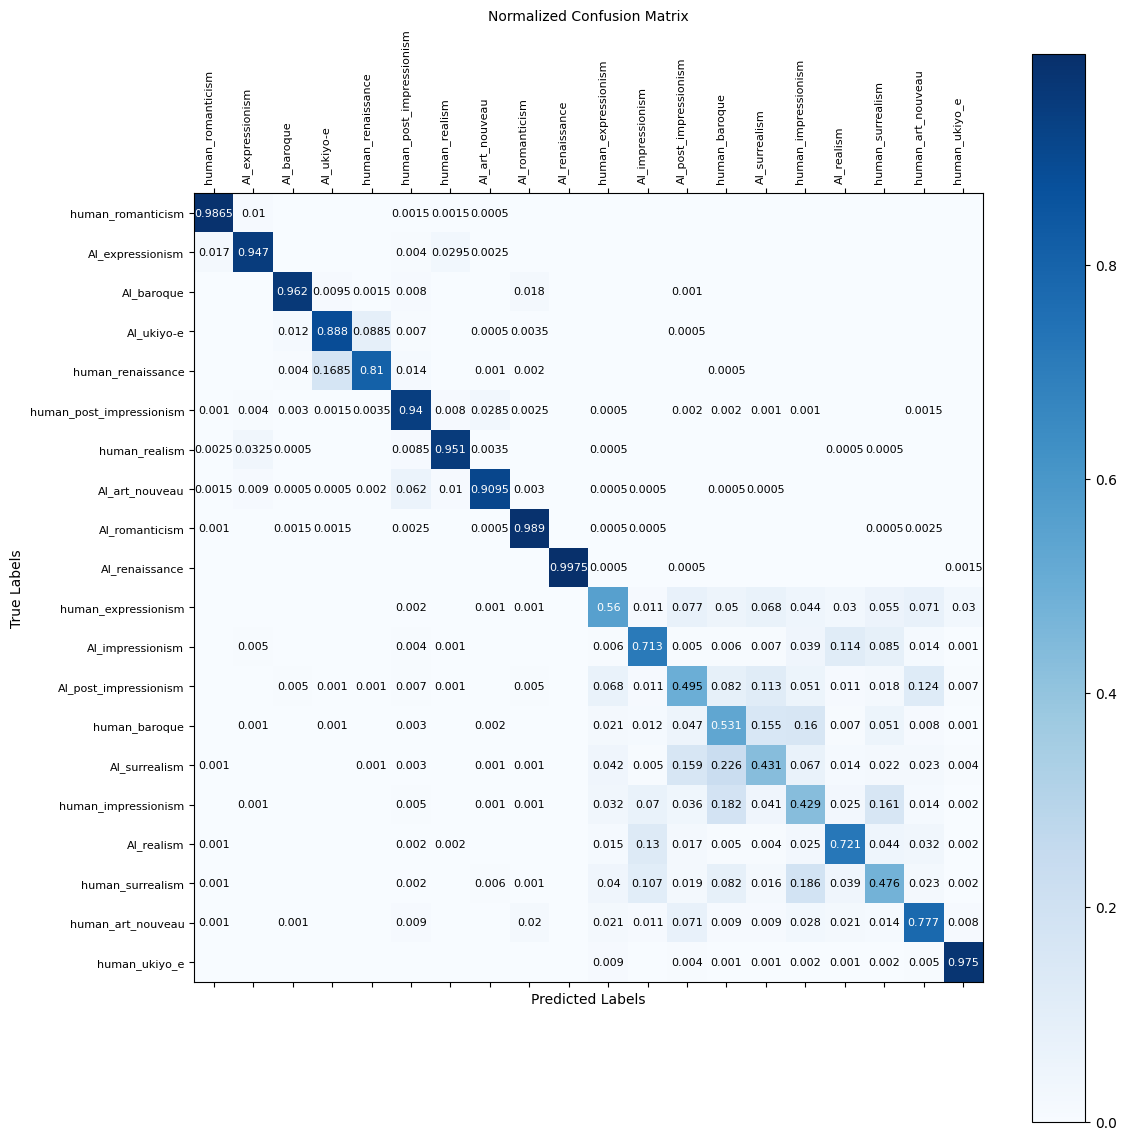


Classification Report:
                          precision    recall  f1-score   support

       human_romanticism       0.98      0.99      0.98      2000
        AI_expressionism       0.94      0.95      0.94      2000
              AI_baroque       0.98      0.96      0.97      2000
              AI_ukiyo-e       0.83      0.89      0.86      2000
       human_renaissance       0.89      0.81      0.85      2000
human_post_impressionism       0.88      0.94      0.91      2000
           human_realism       0.95      0.95      0.95      2000
          AI_art_nouveau       0.96      0.91      0.93      2000
          AI_romanticism       0.96      0.99      0.97      2000
          AI_renaissance       1.00      1.00      1.00      2000
     human_expressionism       0.68      0.56      0.62      1000
        AI_impressionism       0.67      0.71      0.69      1000
   AI_post_impressionism       0.53      0.49      0.51      1000
           human_baroque       0.45      0.53      

In [ ]:
# Analyze test results
metrics = analyze_test_results(
    test_loss=test_loss,
    test_accuracy=test_accuracy,
    test_per_class_accuracy=test_per_class_accuracy,
    all_labels=all_labels,
    all_predictions=all_predictions,
    classes=test_classes
)

In comparison to previously trained model this ResNet18 model with data augmantation, non-frozen parameters and increased image resolution was able to provide accuracy of 82.9% on the test set which is significant improvement in comarison to other tries.

#### Predictions analysis

Now let's look into more details into correctly and incorrectly classified artworks of the validation set.

In [ ]:
# Process Data to print some images
preprocessor = CustomDatasetPreprocessor(dataset_path)
preprocessor.preprocess(fraction=1)

# Get dataset splits
train_data, validation_data, test_data = preprocessor.get_splits()

# Print images from train dataset + check how different transformations work
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
   # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Prepare the training dataset and DataLoader
test_dataset = AIArtbench(dataframe=test_data, subset=Subset.TEST, transform=test_transform)

# Get unique class names
classes = test_dataset.get_classes()

In [ ]:
# Convert all numeric labels and predictions into text using the classes dictionary
df = test_data.copy()
df['true_label'] = [classes[label] for label in all_labels]
df['predicted_label'] = [classes[label] for label in all_predictions]

In [ ]:
def plot_images(image_paths, labels, predictions, num_images=10, title="Images"):
    """
    Plots a specified number of images with their true and predicted labels.

    :param image_paths: List of image file paths
    :param labels: List of true labels for the images
    :param predictions: List of predicted labels for the images
    :param num_images: Number of images to plot (default is 10)
    :param title: Title of the plot (default is "Images")
    """
    # Calculate the number of rows and columns dynamically
    rows = (num_images + 4) // 5
    cols = 5

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.ravel()

    for i in range(num_images):  # Plot the specified number of images
        img_path = image_paths[i]
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"True: {labels[i]}\nPred: {predictions[i]}", fontsize=10, pad=10)
        axes[i].axis('off')

    # Adjust layout to prevent overlap
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.suptitle(title, fontsize=16)
    plt.show()

In [ ]:
# Identify correct and incorrect predictions
df['correct'] = df['true_label'] == df['predicted_label']

# Separate correctly and incorrectly classified images
correct_df = df[df['correct'] == True]
incorrect_df = df[df['correct'] == False]

# Example: Specify how many images to plot
num_incorrect = 20
num_correct = 20

# Select the number of incorrect and correct images to plot
incorrect_images = incorrect_df['filepath'].head(num_incorrect).values
incorrect_labels = incorrect_df['true_label'].head(num_incorrect).values
incorrect_predictions = incorrect_df['predicted_label'].head(num_incorrect).values

correct_images = correct_df['filepath'].head(num_correct).values
correct_labels = correct_df['true_label'].head(num_correct).values
correct_predictions = correct_df['predicted_label'].head(num_correct).values

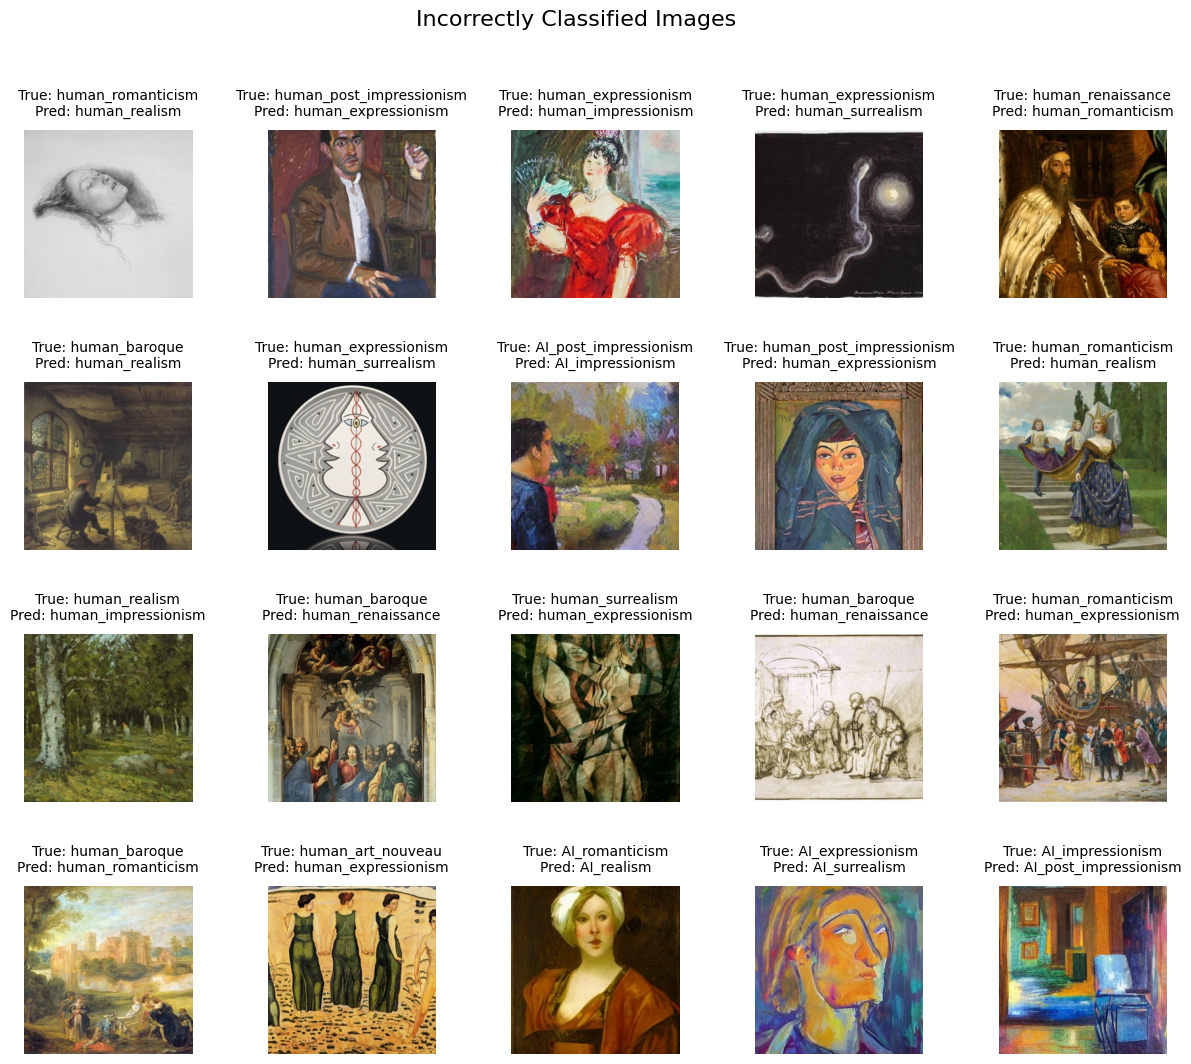

In [ ]:
# Plot incorrectly classified images
plot_images(incorrect_images, incorrect_labels, incorrect_predictions, num_images=num_incorrect, title="Incorrectly Classified Images")

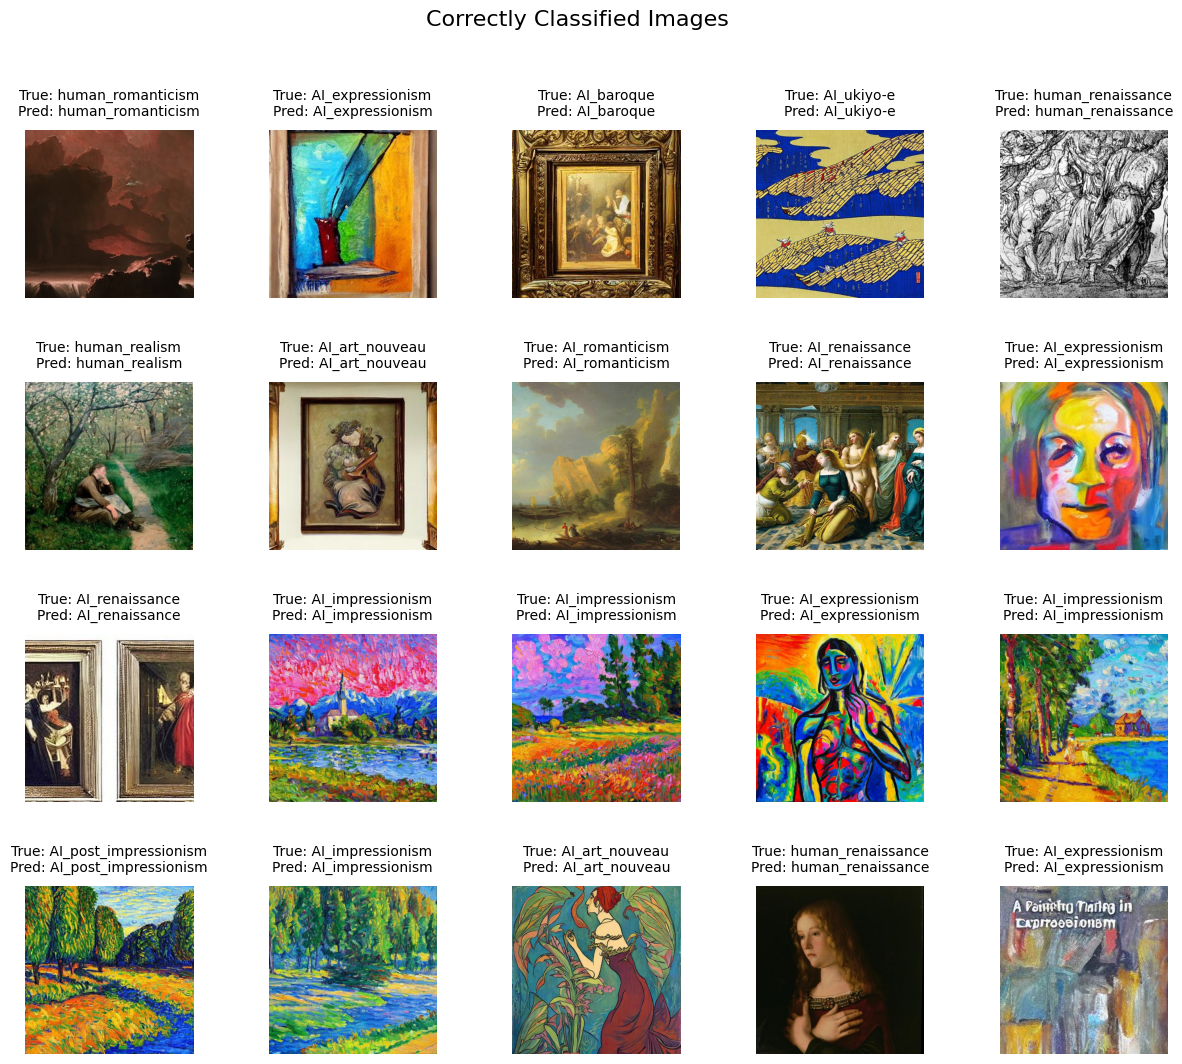

In [ ]:
# Plot correctly classified images
plot_images(correct_images, correct_labels, correct_predictions, num_images=num_correct, title="Correctly Classified Images")